In [24]:
import pandas as pd
import pandas_datareader
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

In [25]:
from lib.attribution.Famma_French.famma_french import FammaFrench
from lib.attribution.VaR.value_at_risk import VaR

In [26]:
import requests
import re
import json
from bs4 import BeautifulSoup

In [27]:
import warnings
warnings.filterwarnings('ignore')

Attributes the performance of a portfolio to various market factors. Measures the contribution of each factor to the total or excess return of the portfolio.

# Portfolio

In [28]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0"
}

def main(url, tickers):
    with requests.Session() as req:
        req.headers.update(headers)    
        frames = []
        for key in tickers:
            r = req.get(url.format(key))
            print(f"Extracting: {r.url}")      
            rows = []
            for line in r.text.splitlines():
                if not line.startswith('etf_holdings.formatted_data'):
                    continue
                data = json.loads(line[30:-1])
                for holding in data:
                    goal = re.search(r'etf/([^"]*)', holding[1])
                    if goal:
                        rows.append([goal.group(1), *holding[2:5]])
            df = pd.DataFrame(rows, columns = ['Symbol', 'Shares', 'Weight', '52 week change'])
            for err in ['NaN', 'NA', 'nan']:
                df["Weight"] = df['Weight'].apply(lambda x : x.replace(err, ''))
            
            df.dropna(how='any', axis=0, inplace=True)
            df = df[['Symbol', 'Shares', 'Weight']]
            df['Shares'] = pd.to_numeric([x.replace(',','') for x in df['Shares']])
            df['Weight'] = pd.to_numeric(df['Weight'])
            df.dropna(how='any', axis=0, inplace=True)

            frames.append(df)
    return frames
            
portfolio = main(url = "https://www.zacks.com/funds/etf/{}/holding", tickers = [ 'QQQ' ])

Extracting: https://www.zacks.com/funds/etf/QQQ/holding


# Overview - Holdings

TODO: pandas data reader does not recognize BRK.B ticker

In [29]:
portfolio[0].head()

,Symbol,Shares,Weight
0,AAPL,140992021,12.39
1,MSFT,65151203,10.82
2,AMZN,88631077,6.40
3,TSLA,9024852,4.13
4,GOOG,2729901,4.01


In [30]:
pf = portfolio[0]

# Returns

In [31]:
ff = FammaFrench(symbols = pf.Symbol.tolist(), weights = pf.Weight.tolist())

In [32]:
portf_returns = ff.get_returns()

In [33]:
# portf_returns.head()

In [34]:
portf_returns = portf_returns.resample('M').sum()
# portf_returns

# Famma French 3 Factor Model

In [35]:
factors = ff.get_ff_three_factor()
# factors

In [36]:
df = portf_returns.merge(factors,  left_index=True, right_index=True, how='inner')
df

,portf_rtn,Mkt-RF,SMB,HML,RF
Date,,,,,
2014-01-31,0.277022,-0.0332,0.0092,-0.0202,0.0000
2014-02-28,6.129839,0.0465,0.0037,-0.0031,0.0000
2014-03-31,-1.380287,0.0043,-0.0187,0.0492,0.0000
2014-04-30,-0.087037,-0.0019,-0.0420,0.0114,0.0000
2014-05-31,4.411392,0.0206,-0.0189,-0.0013,0.0000
...,...,...,...,...,...
2022-02-28,-3.153613,-0.0229,0.0218,0.0309,0.0000
2022-03-31,5.114749,0.0305,-0.0161,-0.0182,0.0001
2022-04-30,-12.821570,-0.0946,-0.0140,0.0616,0.0001


In [37]:
summary, results = ff.three_factor_model(df)

In [38]:
print(summary)

                            OLS Regression Results                            
Dep. Variable:           portf_ex_rtn   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     297.7
Date:                Sat, 30 Jul 2022   Prob (F-statistic):           4.33e-49
Time:                        17:39:40   Log-Likelihood:                -187.69
No. Observations:                 102   AIC:                             383.4
Df Residuals:                      98   BIC:                             393.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0864      0.158      6.883      0.0

<AxesSubplot:title={'center':'Rolling Fama-French 3 Factor model'}, xlabel='Date'>

<Figure size 1440x504 with 0 Axes>

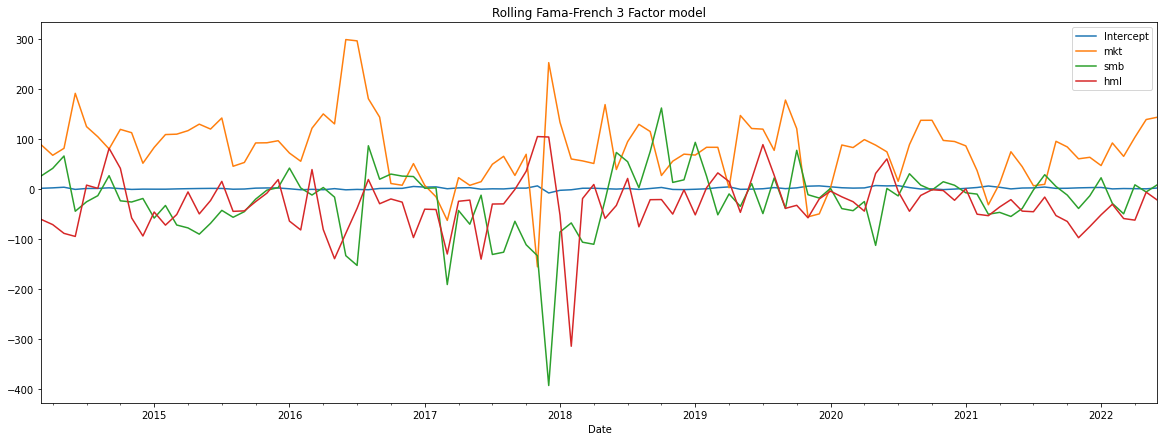

In [39]:
plt.figure(figsize=(20, 7))

results.plot(title=f'Rolling Fama-French 3 Factor model')

# Famma French Industry Factor Model

In [40]:
factors = ff.get_ff_industry_factors()
# factors

In [41]:
df = portf_returns.merge(factors,  left_index=True, right_index=True, how='inner')
df

,portf_rtn,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,,
2014-01-31,0.277022,-0.0570,-0.0369,-0.0425,-0.0688,-0.0117,-0.0380,-0.0644,0.0157,0.0249,-0.0444
2014-02-28,6.129839,0.0346,0.0787,0.0541,0.0559,0.0521,0.0263,0.0534,0.0649,0.0307,0.0347
2014-03-31,-1.380287,0.0326,-0.0106,0.0033,0.0246,-0.0083,0.0017,-0.0058,-0.0254,0.0268,0.0233
2014-04-30,-0.087037,0.0142,0.0034,0.0093,0.0567,-0.0124,0.0039,-0.0094,-0.0029,0.0397,-0.0164
2014-05-31,4.411392,0.0344,0.0069,0.0125,0.0086,0.0349,0.0384,0.0095,0.0189,0.0000,0.0172
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,-3.153613,-0.0053,-0.0721,-0.0123,0.0808,-0.0515,0.0026,-0.0155,-0.0105,-0.0111,-0.0086
2022-03-31,5.114749,0.0041,0.1476,0.0088,0.0998,0.0327,-0.0247,0.0303,0.0515,0.0968,0.0152
2022-04-30,-12.821570,0.0226,-0.1693,-0.0527,-0.0110,-0.1264,-0.1071,-0.0990,-0.0674,-0.0371,-0.0891


In [42]:
summary, results = ff.industry_factor_model(df)

In [43]:
print(summary)

                            OLS Regression Results                            
Dep. Variable:              portf_rtn   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     249.5
Date:                Sat, 30 Jul 2022   Prob (F-statistic):           1.41e-61
Time:                        17:39:47   Log-Likelihood:                -135.01
No. Observations:                 102   AIC:                             292.0
Df Residuals:                      91   BIC:                             320.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7243      0.101      7.152      0.0

<AxesSubplot:title={'center':'Rolling Fama-French Industry Factor model'}, xlabel='Date'>

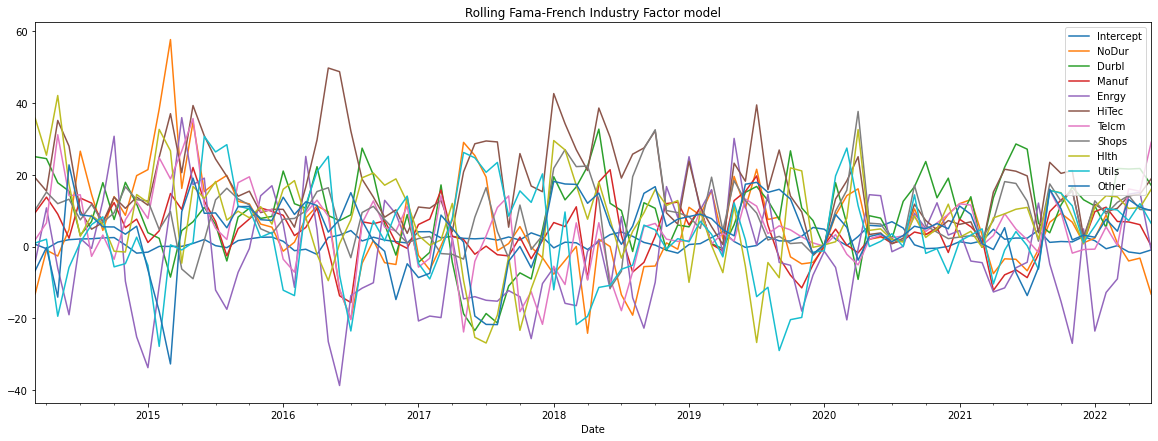

In [44]:
plt.rcParams["figure.figsize"] = (20,7)

results.plot(title=f'Rolling Fama-French Industry Factor model')

# VaR

VaR assumes that the price returns of our assets are normaly distributed

In [45]:
var = VaR(symbols = pf.Symbol.tolist(), weights = pf.Weight.tolist(), start_date='2020-01-01')

In [46]:
returns = var.get_returns()

In [47]:
returns

,AAPL,MSFT,AMZN,TSLA,GOOG,GOOGL,NVDA,META,PEP,COST,...,ANSS,ALGN,CEG,VRSN,NTES,SWKS,SPLK,OKTA,DOCU,portf_rtn
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.009722,-0.012452,-0.012139,0.029633,-0.004907,-0.005231,-0.016006,-0.005291,-0.001399,0.000823,...,-0.010093,-0.011421,0.000000,0.021095,-0.012291,-0.024821,0.000526,0.008354,-0.004480,-0.706893
2020-01-06,0.007968,0.002585,0.014886,0.019255,0.024657,0.026654,0.004194,0.018834,0.003834,0.000274,...,-0.009262,0.019398,0.000000,0.009259,-0.001848,-0.017615,0.015783,0.043453,-0.002250,0.657368
2020-01-07,-0.004703,-0.009118,0.002092,0.038801,-0.000624,-0.001932,0.012107,0.002164,-0.015718,-0.001576,...,0.008170,-0.009864,0.000000,0.002318,0.012251,0.009523,-0.006798,-0.004375,-0.001990,0.153055
2020-01-08,0.016086,0.015928,-0.007809,0.049205,0.007880,0.007118,0.001876,0.010138,0.005149,0.011464,...,0.004130,0.010386,0.000000,0.004626,0.009085,0.015892,0.015318,0.021645,0.013690,0.894838
2020-01-09,0.021241,0.012493,0.004799,-0.021945,0.011044,0.010498,0.010983,0.014311,0.000668,0.016051,...,0.014356,0.036853,0.000000,0.023169,0.022235,0.000920,-0.007961,0.023656,-0.006162,0.826331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,-0.007398,-0.005876,-0.010456,-0.013995,-0.001384,-0.003614,-0.017033,-0.015478,0.001415,-0.001095,...,-0.008648,-0.051941,0.017778,-0.020831,0.018517,-0.002168,-0.017771,-0.027563,-0.016292,-0.533988
2022-07-26,-0.008826,-0.026774,-0.052254,-0.035664,-0.025598,-0.023161,-0.028842,-0.045005,0.011657,-0.032525,...,-0.016168,-0.000833,0.009825,-0.022928,-0.025617,-0.028061,-0.045762,-0.080391,-0.050315,-1.970564
2022-07-27,0.034235,0.066852,0.053654,0.061655,0.077390,0.076557,0.076030,0.065536,-0.001397,0.020276,...,0.044808,0.042682,0.000541,0.023184,0.018870,0.040537,0.032445,0.057585,0.067431,4.342091


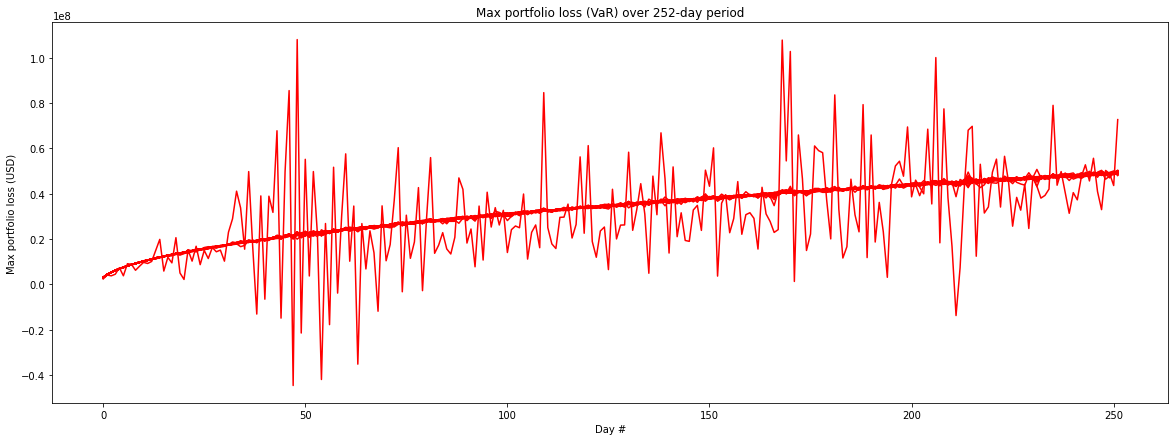

In [48]:
var.calculate_value_at_risk()

# Brinson

# PCA